# K-BALD: Result Visualization
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns
import torch

import wandb

In [ ]:
import functools
import operator

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
mpl.rcParams["figure.dpi"] = 150
sns.set_style("whitegrid")

In [ ]:
plt.rcParams.update({
    #"figure.facecolor":  (1.0, 0.0, 0.0, 0.3),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 0.5),  # blue  with alpha = 20%
})

In [ ]:
def savefig(g, path):
    g.savefig(path, transparent=False, dpi=300, bbox_inches="tight", pad_indices=0)

In [ ]:
c = sns.color_palette()
c

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

# Import WandB data

In [ ]:
api = wandb.Api(timeout=30)

In [ ]:
runs = api.runs("oatml-andreas-kirsch/balds", filters=dict(tags="sievebald_blog", state="finished"))

In [ ]:
len(runs)

45

In [ ]:
runs[0].config

{'seed': 6594,
 'device': 'cuda',
 'coldness': 1,
 'Dataclass': 'batchbald_redux.unified_experiment.UnifiedExperiment',
 'epig_dtype': 'torch.float64',
 'temperature': 1,
 'dataset_info': '{\'training\': "(\'MNIST (Train, seed=0, 55904 samples)\')x4 + 𝓝(0;σ=0.1)", \'test\': "\'MNIST (Test)\'"}',
 'ensemble_size': 1,
 'stochastic_mode': None,
 'acquisition_size': 5,
 'max_training_set': 320,
 'num_pool_samples': 100,
 'train_eval_model': 'batchbald_redux.train_eval_model.TrainSelfDistillationEvalModel',
 'epig_bootstrap_type': 'BootstrapType.NO_BOOTSTRAP',
 'max_training_epochs': 300,
 'acquisition_function': 'batchbald_redux.acquisition_functions.batchbald.BatchBALD',
 'num_training_samples': 1,
 'epig_bootstrap_factor': 1,
 'model_trainer_factory': 'batchbald_redux.models.MnistModelTrainer',
 'resnet18_dropout_head': True,
 'evaluation_set_indices': [],
 'experiment_data_config': {'Dataclass': 'batchbald_redux.experiment_data.StandardExperimentDataConfig',
  'id_repetitions': 4,
  'id

In [ ]:
runs[0].config["initial_training_set_indices"]

[47227,
 11511,
 18383,
 41080,
 32837,
 24393,
 23904,
 11784,
 20439,
 35043,
 27367,
 30426,
 32361,
 26116,
 24386,
 4689,
 44895,
 24211,
 17212,
 3478]

In [ ]:
r = runs[0]

In [ ]:
history = r.history()
df = history[["_step","accuracy"]]
df["training_set_size"] = len(r.config["initial_training_set_indices"]) + r.config["acquisition_size"]*df["_step"]
del df["_step"]
df

<ipython-input-14-6695629c6a47>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["training_set_size"] = len(r.config["initial_training_set_indices"]) + r.config["acquisition_size"]*df["_step"]


,accuracy,training_set_size
0,0.6025,20
1,0.6757,25
2,0.7498,30
3,0.7439,35
4,0.7450,40
...,...,...
56,0.9656,300
57,0.9673,305
58,0.9689,310
59,0.9617,315


In [ ]:
def get_df_from_run(run):
    history = run.history()    
    df = history[["_step","accuracy"]]
    df = df.copy()
    
    df["training_set_size"] = len(run.config["initial_training_set_indices"]) + run.config["acquisition_size"]*df["_step"]
    del df["_step"]    
    
    df["seed"] = run.config["seed"]   
    df["id_repetitions"] = run.config["experiment_data_config"]["id_repetitions"]
    df["acquisition_size"] = run.config["acquisition_size"]
    
    df["acquisition_function"] = run.config["acquisition_function"]
        
    return df

In [ ]:
df = pd.concat([get_df_from_run(run) for run in runs])

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.acquisition_function.unique()

array(['batchbald_redux.acquisition_functions.batchbald.BatchBALD',
       'batchbald_redux.acquisition_functions.sievebald.SieveBALD'],
      dtype=object)

In [ ]:
acquisition_function_map = {'batchbald_redux.acquisition_functions.batchbald.BatchBALD': "BatchBALD",
       'batchbald_redux.acquisition_functions.sievebald.SieveBALD': "2-BALD"}
df["simple_acquisition_function"] = df["acquisition_function"].map(acquisition_function_map)
df["Acquisition Function"] = df["simple_acquisition_function"] + " " + df["acquisition_size"].astype(str)

/home/blackhc/anaconda3/envs/active_learning/lib/python3.8/site-packages/seaborn/axisgrid.py:65: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_indices" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(*args, **kwargs)


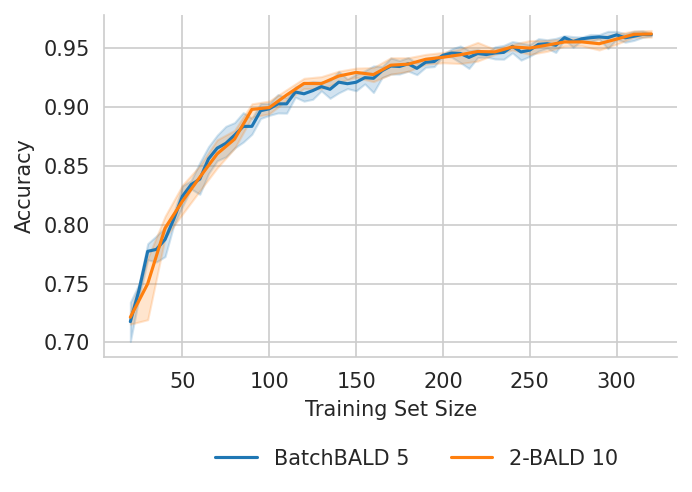

In [ ]:
sub_df = df[(df["id_repetitions"] == 1) & (df["Acquisition Function"].isin(["BatchBALD 5", "2-BALD 10"]))]
g = sns.relplot(
    data=sub_df,
    x="training_set_size",
    y="accuracy",
    #col="acquisition_size",
    #col="id_repetitions",
    hue="Acquisition Function",
    #palette=sns.color_palette("crest", as_cmap=True),
    kind="line",
    aspect=1.62,
    height=3,
)
g.set_axis_labels("Training Set Size", "Accuracy")
g.set_titles("{col_name}")
sns.move_legend(g, "lower left", bbox_to_anchor=(0.25, -0.1), ncol=3, title=None)
savefig(g, "mnist_kbald_vs_batchbald.svg")

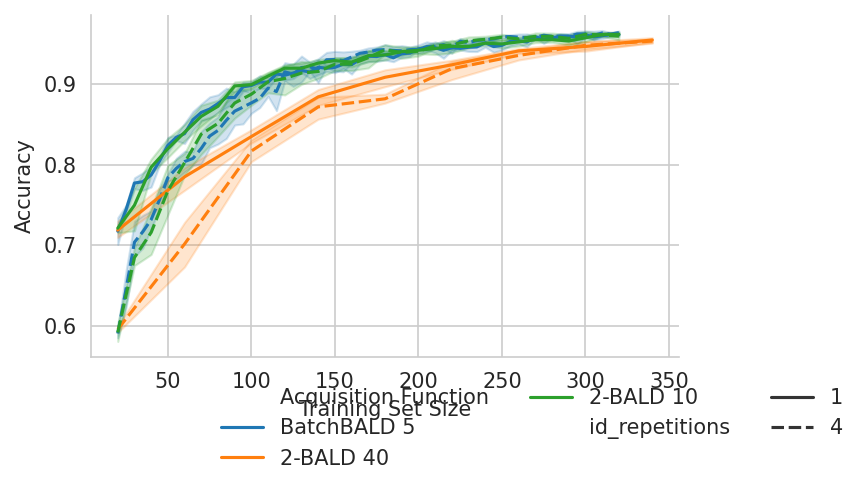

In [ ]:
sub_df = df[(df["Acquisition Function"].isin(["BatchBALD 5", "2-BALD 10", "2-BALD 40"]))]
g = sns.relplot(
    data=sub_df,
    x="training_set_size",
    y="accuracy",
    #col="acquisition_size",
    #col="id_repetitions",
    hue="Acquisition Function",
    style="id_repetitions",
    #palette=sns.color_palette("crest", as_cmap=True),
    kind="line",
    aspect=1.62,
    height=3,
)
g.set_axis_labels("Training Set Size", "Accuracy")
g.set_titles("{col_name}")
sns.move_legend(g, "lower left", bbox_to_anchor=(0.25, -0.1), ncol=3, title=None)
#savefig(g, "mnist_kbald_vs_batchbald.svg")

/home/blackhc/anaconda3/envs/active_learning/lib/python3.8/site-packages/seaborn/axisgrid.py:65: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_indices" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(*args, **kwargs)


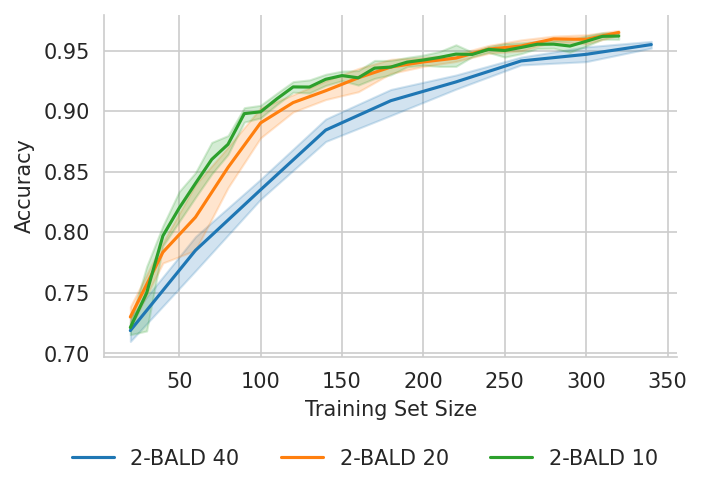

In [ ]:
sub_df = df[(df["id_repetitions"] == 1) & (df["Acquisition Function"].isin(["2-BALD 10", "2-BALD 20", "2-BALD 40"]))]
g = sns.relplot(
    data=sub_df,
    x="training_set_size",
    y="accuracy",
    #col="acquisition_size",
    #col="id_repetitions",
    hue="Acquisition Function",
    #palette=sns.color_palette("crest", as_cmap=True),
    kind="line",
    aspect=1.62,
    height=3,
)
g.set_axis_labels("Training Set Size", "Accuracy")
g.set_titles("{col_name}")
sns.move_legend(g, "lower left", bbox_to_anchor=(0.1, -0.1), ncol=3, title=None)
savefig(g, "mnist_acquisition_size_ablation.svg")